In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch
import sklearn
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from torch.optim.lr_scheduler import StepLR
import gc

In [2]:
random_seed = 2021
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

In [304]:
df = pd.read_csv('./data/train.csv',engine='python')
test_df = pd.read_csv('./data/test.csv',engine='python')
test_df2 = pd.read_csv('./data/test.csv',engine='python')

In [305]:
def processing(dt):
    df_date = dt['Date(MM/DD/YYYY)'].tolist()
    month = list()
    day = list()
    year = list()

    for date in df_date:
        a = date.split('/')
        month.append(a[0])
        day.append(a[1])
        year.append(a[2])

    dt.drop('Date(MM/DD/YYYY)', axis=1, inplace=True)
    dt.loc[:,'Month']=pd.Series(month, index=dt.index)
    dt.loc[:,'Day']=pd.Series(day, index=dt.index)
    dt.loc[:,'Year']=pd.Series(year, index=dt.index)
    
    return dt

In [306]:
df = processing(df)
test_df = processing(test_df)
test_df2 = processing(test_df2)

In [177]:
test_df

,Hour,Solar Radiance(w/m^2),Temperature(C),Solar Power(kW),Month,Day,Year
0,0,-2.9380,5.5313,0.0,1,1,2020
1,1,-2.5765,5.8106,0.0,1,1,2020
2,2,-2.5086,5.3325,0.0,1,1,2020
3,3,-1.9340,5.5484,0.0,1,1,2020
4,4,-2.0231,4.7662,0.0,1,1,2020
...,...,...,...,...,...,...,...
8755,19,-1.5387,9.0635,0.0,12,31,2020
8756,20,-3.0244,8.5637,0.0,12,31,2020
8757,21,-2.5433,7.9824,0.0,12,31,2020
8758,22,-2.6706,7.7303,0.0,12,31,2020


In [7]:
common_features = ['Solar Radiance(w/m^2)','Temperature(C)','Solar Power(kW)']

In [8]:
def kdeplot_features(df_train,df_test, feature, title):
    values_train = df_train[feature]
    values_test = df_test[feature]
     
    plt.figure(figsize = (20, 3))
    
    sns.kdeplot(values_train, color = 'red')
    sns.kdeplot(values_test, color = 'black')
    
    plt.title(title, fontsize=20)
    plt.legend()
    plt.show();
    
    # del values_train , values_test
    # gc.collect()

No handles with labels found to put in legend.


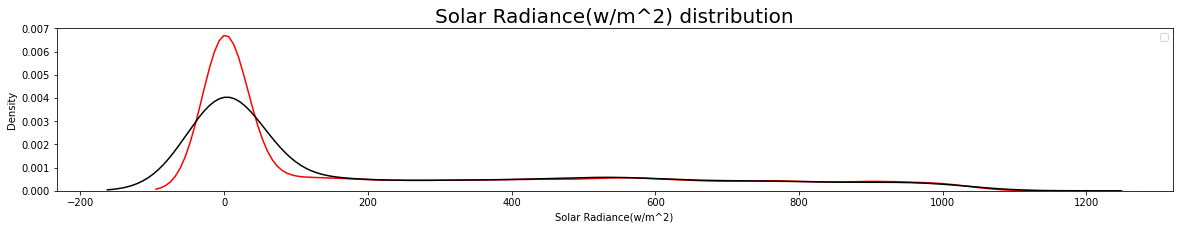

No handles with labels found to put in legend.


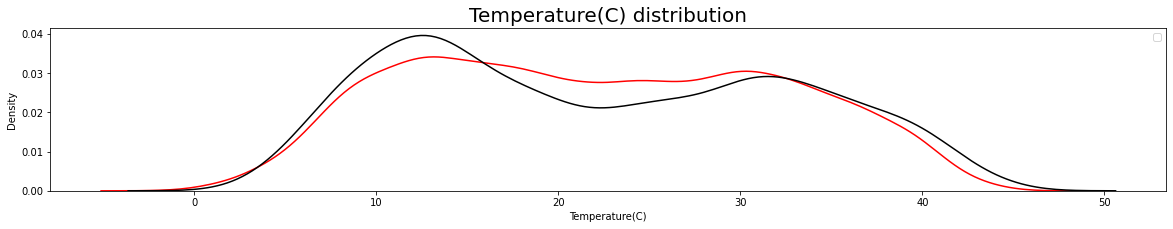

No handles with labels found to put in legend.


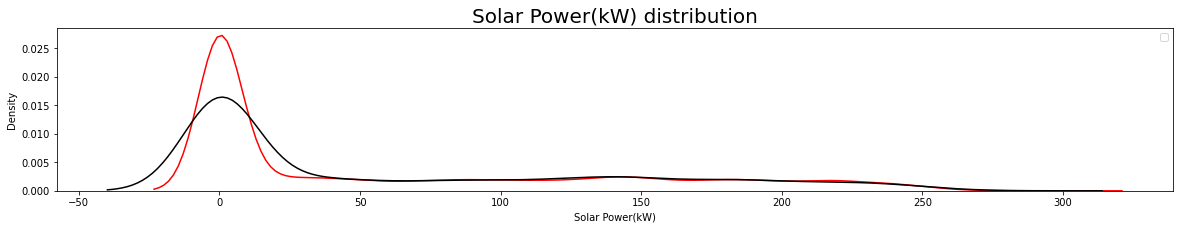

In [215]:
for feature in common_features:
    kdeplot_features(df,test_df, feature=feature, title = feature + " distribution")

In [9]:
df[df['Solar Radiance(w/m^2)'].isnull()].count()

Hour                     1848
Solar Radiance(w/m^2)       0
Temperature(C)              0
Solar Power(kW)             0
Month                    1848
Day                      1848
Year                     1848
dtype: int64

In [219]:
df.describe()

,Hour,Solar Radiance(w/m^2),Temperature(C),Solar Power(kW)
count,105120.000000,103272.000000,103272.000000,103272.000000
mean,11.500000,236.417396,22.116514,58.596109
std,6.922219,317.933331,10.057908,78.085571
min,0.000000,0.000000,-2.121600,0.000000
25%,5.750000,0.000000,13.643450,0.000000
50%,11.500000,10.191550,21.702900,2.558864
75%,17.250000,466.469025,30.478050,118.431006
max,23.000000,1154.582000,46.144500,297.681980


In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105120 entries, 0 to 105119
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Hour                   105120 non-null  int64  
 1   Solar Radiance(w/m^2)  103272 non-null  float64
 2   Temperature(C)         103272 non-null  float64
 3   Solar Power(kW)        103272 non-null  float64
 4   Month                  105120 non-null  object 
 5   Day                    105120 non-null  object 
 6   Year                   105120 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 5.6+ MB


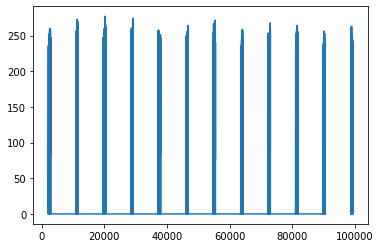

In [221]:
plt.plot(df.loc[(df['Month']=='4') &(df['Temperature(C)']!=-99999.0 ), 'Solar Power(kW)'])

In [1]:
df.loc[(df['Month']=='2')&(df['Temperature(C)']!=-99999.0 ),'Temperature(C)','Solar Power(kW)'].mean()


NameError: name 'df' is not defined

In [10]:
df.loc[df['Solar Radiance(w/m^2)']<0,'Solar Radiance(w/m^2)'] = 0

In [11]:
df.loc[df['Temperature(C)']==-99999.0, ['Temperature(C)','Solar Power(kW)']] = 12.475700, 0

In [12]:
df.describe()

,Hour,Solar Radiance(w/m^2),Temperature(C),Solar Power(kW)
count,105120.000000,103272.000000,103272.000000,103272.000000
mean,11.500000,236.417396,22.116514,58.596109
std,6.922219,317.933331,10.057908,78.085571
min,0.000000,0.000000,-2.121600,0.000000
25%,5.750000,0.000000,13.643450,0.000000
50%,11.500000,10.191550,21.702900,2.558864
75%,17.250000,466.469025,30.478050,118.431006
max,23.000000,1154.582000,46.144500,297.681980


In [307]:
test_df.loc[test_df['Solar Radiance(w/m^2)']<0,'Solar Radiance(w/m^2)'] = 0

In [212]:
test_df.describe()

,Hour,Solar Radiance(w/m^2),Temperature(C),Solar Power(kW)
count,8760.000000,6912.000000,6912.000000,6912.000000
mean,11.500000,238.308595,22.134330,59.020715
std,6.922582,317.514732,10.620961,77.824192
min,0.000000,0.000000,1.805400,0.000000
25%,5.750000,0.000000,12.808525,0.000000
50%,11.500000,9.755750,20.855550,2.427515
75%,17.250000,477.700650,31.411175,121.124963
max,23.000000,1084.883200,45.179000,274.091265


In [308]:
test_df = test_df.fillna(method='ffill')

No handles with labels found to put in legend.


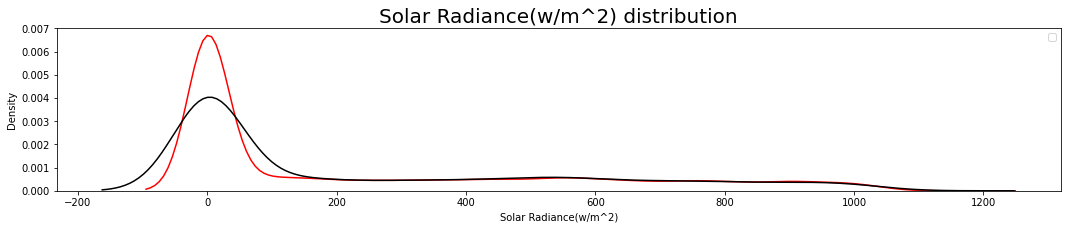

No handles with labels found to put in legend.


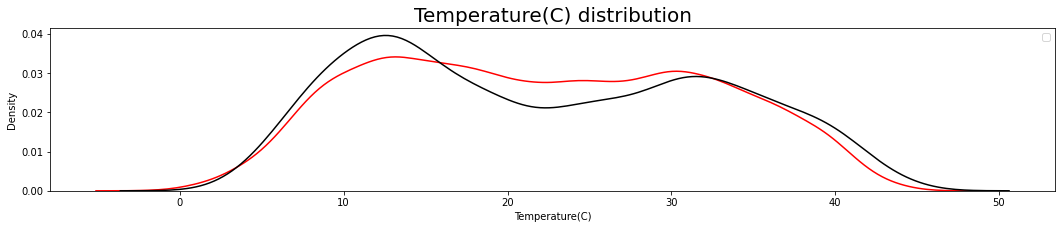

No handles with labels found to put in legend.


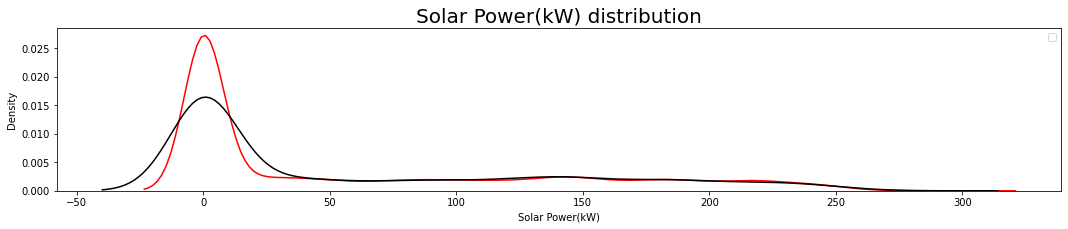

In [213]:
for feature in common_features:
    kdeplot_features(df,test_df, feature=feature, title = feature + " distribution")

In [14]:
sc = RobustScaler()
df = sc.fit_transform(df[['Solar Radiance(w/m^2)','Temperature(C)','Solar Power(kW)']])
df[:15]
# df = df[['Solar Radiance(w/m^2)','Temperature(C)','Solar Power(kW)']]

array([[-0.02184829, -1.00127119, -0.02160637],
       [-0.02184829, -1.02844142, -0.02160637],
       [-0.02184829, -1.0719827 , -0.02160637],
       [-0.02184829, -1.1188861 , -0.02160637],
       [-0.02184829, -1.18948475, -0.02160637],
       [-0.02184829, -1.2236406 , -0.02160637],
       [-0.02184829, -1.26138429, -0.02160637],
       [-0.02184829, -1.27401898, -0.02160637],
       [ 0.18110817, -1.22831549,  0.20219895],
       [ 0.55810319, -1.11446663,  0.61244853],
       [ 0.89170991, -0.99782591,  0.96834531],
       [ 0.900199  , -0.89548905,  0.96972341],
       [ 0.91931345, -0.81966307,  0.98435915],
       [ 1.07917337, -0.71627481,  1.14579133],
       [ 0.77991127, -0.70905754,  0.82800835]])

In [15]:
# def sliding_windows(data, seq_length):
#     x_list = []
#     y_list = []

#     for i in tqdm(range(len(data)-2*seq_length-1)):
#         x = data[i:(i+seq_length)]
#         y = data[(i+seq_length):(i+2*seq_length)]
#         # x = data.iloc[i:(i+seq_length)]
#         # y = data.iloc[i+seq_length:i+2*seq_length]
#         x_list.append(x)
#         y_list.append(y)

#     return np.array(x_list),np.array(y_list)

In [19]:
# train_x, train_y = sliding_windows(df, 7)

  0%|          | 0/105105 [00:00<?, ?it/s]

In [138]:
split_idx = 96264
train_data = df[:split_idx]

In [139]:
shift_hours = 24*7
train_x, train_y = train_data[:-shift_hours], train_data[shift_hours:]

ValueError: x and y must be the same size

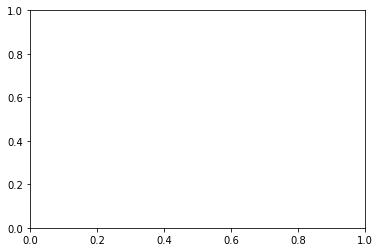

In [250]:
for i in range(100,102):
    plt.scatter(train_x.shape[1], train_y[i][0], marker='x', c='red')
    plt.scatter(train_x.shape[1], train_y[i][1], marker='o', c='blue')
    plt.scatter(train_x.shape[1], train_y[i][2], marker='x', c='black')
    plot_data(train_x[i], label='Solar Power')
    # plot_data(train_x[i][1], label='Solar Power2')
    # plot_data(train_x[i][2], label='Solar Power3')

In [140]:
print(train_x.shape, train_y.shape)

(96096, 3) (96096, 3)


In [141]:
train_x = train_x.reshape(int(train_x.shape[0]/shift_hours),shift_hours,3)
train_y = train_y.reshape(int(train_y.shape[0]/shift_hours),shift_hours,3)

In [72]:
print(train_x.shape, train_y.shape)

(572, 168, 3) (572, 168, 3)


In [143]:
training_set_size = 500
# train_X = torch.tensor(train_x[:training_set_size], dtype=torch.float32)
# train_Y = torch.tensor(train_y[:training_set_size], dtype=torch.float32)

# valid_X = torch.tensor(train_x[training_set_size:], dtype=torch.float32)
# valid_Y = torch.tensor(train_y[training_set_size:], dtype=torch.float32)

train_X = train_x[:training_set_size].astype(float)
train_Y = train_y[:training_set_size].astype(float)

valid_X = train_x[training_set_size:].astype(float)
valid_Y = train_y[training_set_size:].astype(float)

In [144]:
print(len(train_X), len(valid_X))
print(len(train_X)+len(valid_X))

500 72
572


In [126]:
class simple_dataset(Dataset):
    def __init__(self, x, y):
        super(simple_dataset, self).__init__()
        
        self.x = x
        self.y = y
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.y)

In [127]:
train_set = simple_dataset(train_X, train_Y)
test_set = simple_dataset(valid_X, valid_Y)
train_loader = DataLoader(dataset=train_set, batch_size=16, num_workers=2, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=1, num_workers=2, shuffle=False)

In [128]:
class GRU_model(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers):
        super(GRU_model, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.activation = nn.LeakyReLU(0.2)
        # Layers
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).cuda()
        
        _, h_out = self.gru(x, h_0)
        h_out = h_out[-1]
        # h_out = self.activation(h_out)
        out = self.fc(h_out)
        # print(out.size())
        return out

In [129]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [130]:
num_epochs = 5
learning_rate = 1e-4

output_size = 3*168
input_size = 3*168
hidden_size = 1024
num_layers = 3

model = GRU_model(output_size, input_size, hidden_size, num_layers)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [131]:
model = model.cuda()
train_loss_list = []
for epoch in tqdm(range(num_epochs)):
    for batch_ep, (input_seq, label) in tqdm(enumerate(train_loader)):
        input_seq = input_seq.reshape(16,1,-1)
        label = label.reshape(16,1,-1)
        input_seq = input_seq.cuda()
        label = label.cuda()
        print(input_seq.size(),label.size())
        preds = model(input_seq)
        loss = criterion(preds, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_list.append(loss)
        if batch_ep % 1000 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

torch.Size([16, 1, 504]) torch.Size([16, 1, 504])
Epoch: 0, loss: 0.65611
torch.Size([16, 1, 504]) torch.Size([16, 1, 504])
torch.Size([16, 1, 504]) torch.Size([16, 1, 504])
torch.Size([16, 1, 504]) torch.Size([16, 1, 504])
torch.Size([16, 1, 504]) torch.Size([16, 1, 504])
torch.Size([16, 1, 504]) torch.Size([16, 1, 504])
torch.Size([16, 1, 504]) torch.Size([16, 1, 504])
torch.Size([16, 1, 504]) torch.Size([16, 1, 504])
torch.Size([16, 1, 504]) torch.Size([16, 1, 504])
torch.Size([16, 1, 504]) torch.Size([16, 1, 504])
torch.Size([16, 1, 504]) torch.Size([16, 1, 504])
torch.Size([16, 1, 504]) torch.Size([16, 1, 504])
torch.Size([16, 1, 504]) torch.Size([16, 1, 504])
torch.Size([16, 1, 504]) torch.Size([16, 1, 504])
torch.Size([16, 1, 504]) torch.Size([16, 1, 504])
torch.Size([16, 1, 504]) torch.Size([16, 1, 504])
torch.Size([16, 1, 504]) torch.Size([16, 1, 504])
torch.Size([16, 1, 504]) torch.Size([16, 1, 504])
torch.Size([16, 1, 504]) torch.Size([16, 1, 504])
torch.Size([16, 1, 504]) t

RuntimeError: input.size(-1) must be equal to input_size. Expected 504, got 126

In [155]:
from tensorflow import keras
from keras.layers import GRU, Dense
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import EarlyStopping
import keras.backend as K

K.clear_session()
model = Sequential()
model.add(GRU(20, activation='relu', input_shape=(shift_hours, 3), return_sequences=True, dropout=0.2))
model.add(Dense(3))
adam = keras.optimizers.Adam(learning_rate =  1e-2)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

model.summary()
early_stop = EarlyStopping(monitor='loss', patience=100, verbose=1)

hist = model.fit(train_X, train_Y, validation_data=(valid_X, valid_Y), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
y_pred = model.predict(valid_X)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 168, 20)           1500      
                                                                 
 dense (Dense)               (None, 168, 3)            63        
                                                                 
Total params: 1,563
Trainable params: 1,563
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
32/32 [==============================] - 5s 117ms/step - loss: 0.1553 - accuracy: 0.4380 - val_loss: 0.0647 - val_accuracy: 0.7143
Epoch 2/50
32/32 [==============================] - 4s 129ms/step - loss: 0.0870 - accuracy: 0.6179 - val_loss: 0.0611 - val_accuracy: 0.6503
Epoch 3/50
32/32 [==============================] - 4s 128ms/step - loss: 0.0745 - accuracy: 0.6166 - val_loss: 0.0624 - val_accuracy: 0.6515
Epoch 4/50
32/32 [======

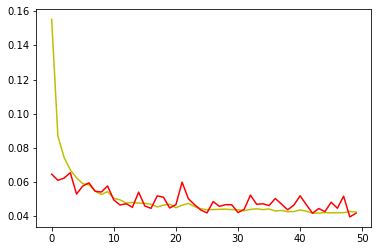

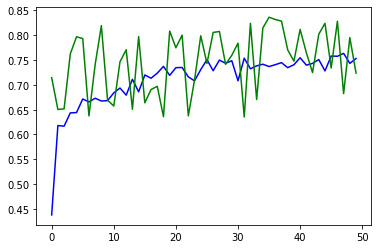

In [156]:
plt.figure(1)
plt.plot(hist.history['loss'], 'y', label='train loss')
plt.plot(hist.history['val_loss'], 'r', label='val loss')

plt.figure(2)
plt.plot(hist.history['accuracy'], 'b', label='train acc')
plt.plot(hist.history['val_accuracy'], 'g', label='val acc')

In [338]:
y_pred.shape

(72, 168, 3)

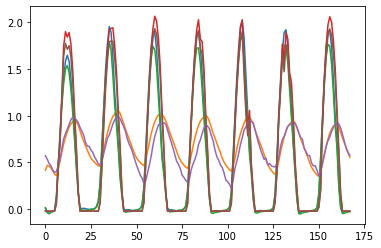

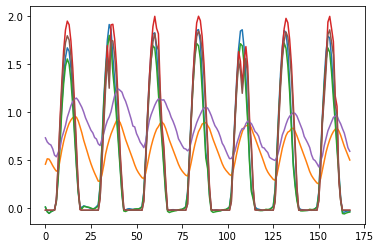

In [339]:
plt.figure(1)
plt.plot(y_pred[2])
plt.plot(valid_Y[2])

plt.figure(2)
plt.plot(y_pred[1])
plt.plot(valid_Y[1])

In [212]:
test_df[10:]

,Hour,Solar Radiance(w/m^2),Temperature(C),Solar Power(kW),Month,Day,Year
10,10,305.6346,7.0477,83.267205,1,1,2020
11,11,327.0414,7.5561,88.891447,1,1,2020
12,12,346.0632,8.2395,93.766040,1,1,2020
13,13,425.8717,9.2413,114.856905,1,1,2020
14,14,443.4677,10.0527,119.152731,1,1,2020
...,...,...,...,...,...,...,...
8755,19,0.0000,9.0635,0.000000,12,31,2020
8756,20,0.0000,8.5637,0.000000,12,31,2020
8757,21,0.0000,7.9824,0.000000,12,31,2020
8758,22,0.0000,7.7303,0.000000,12,31,2020


In [309]:
sc = RobustScaler()
testset = sc.fit_transform(test_df[['Solar Radiance(w/m^2)','Temperature(C)','Solar Power(kW)']])

In [310]:
testset = testset[:8736]

In [311]:
testset.shape

(8736, 3)

In [312]:
test_x, test_y = testset[:-shift_hours], testset[shift_hours:]
test_x = testset.reshape(int(testset.shape[0]/shift_hours),shift_hours,3)
test_y = testset.reshape(int(testset.shape[0]/shift_hours),shift_hours,3)

In [313]:
y_pred_test = model.predict(test_x)

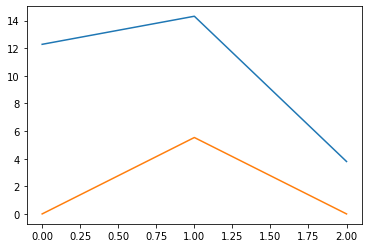

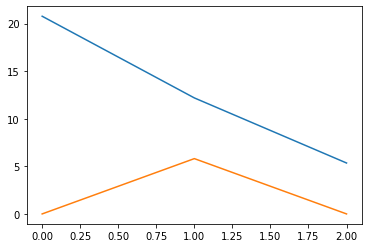

In [331]:
plt.figure(1)
plt.plot(y_pred_test[0])
plt.plot(test_y[0])

plt.figure(2)
plt.plot(y_pred_test[1])
plt.plot(test_y[1])

In [315]:
y_pred_test = y_pred_test.reshape(-1,3)
test_y = test_y.reshape(-1,3)                             

In [316]:
y_pred_test = sc.inverse_transform(y_pred_test)
test_y = sc.inverse_transform(test_y)

In [294]:
y_pred_test

array([[12.277424 , 14.309789 ,  3.7947056],
       [20.770187 , 12.188404 ,  5.3500876],
       [20.481266 , 10.785615 ,  4.95784  ],
       ...,
       [10.29317  , 13.060114 ,  3.1472182],
       [14.207079 , 12.147353 ,  3.986803 ],
       [15.58873  , 11.409597 ,  4.142958 ]], dtype=float32)

In [295]:
test_y

array([[0.    , 5.5313, 0.    ],
       [0.    , 5.8106, 0.    ],
       [0.    , 5.3325, 0.    ],
       ...,
       [0.    , 8.8085, 0.    ],
       [0.    , 7.2568, 0.    ],
       [0.    , 6.8444, 0.    ]])

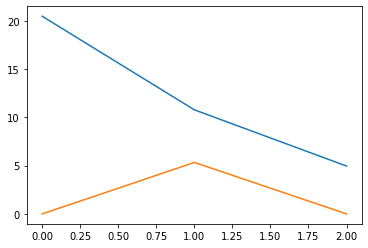

In [296]:
plt.figure(1)
plt.plot(y_pred_test[:][2])
plt.plot(test_y[:][2])

In [317]:
y_pred_test[744:800]

array([[1.62242184e+01, 1.37593298e+01, 4.37064695e+00],
       [1.55835762e+01, 1.32490416e+01, 3.95978928e+00],
       [1.51347857e+01, 1.28424044e+01, 3.59235263e+00],
       [1.58018532e+01, 1.25057392e+01, 3.55167341e+00],
       [1.76511402e+01, 1.22192707e+01, 3.87690711e+00],
       [2.07048073e+01, 1.19729433e+01, 4.60371923e+00],
       [3.09296322e+01, 1.17810602e+01, 6.94379902e+00],
       [5.54009094e+01, 1.16894026e+01, 1.31613846e+01],
       [9.42403183e+01, 1.17114878e+01, 2.31516037e+01],
       [1.53663651e+02, 1.19727106e+01, 3.82964783e+01],
       [2.36276367e+02, 1.25748587e+01, 5.91976357e+01],
       [3.34296051e+02, 1.35043659e+01, 8.39635162e+01],
       [4.25704010e+02, 1.46341095e+01, 1.07188553e+02],
       [4.80168793e+02, 1.59401283e+01, 1.20800644e+02],
       [4.87282043e+02, 1.70848370e+01, 1.21757484e+02],
       [4.45416687e+02, 1.79720974e+01, 1.09608604e+02],
       [3.53661377e+02, 1.86015625e+01, 8.50535812e+01],
       [2.20783905e+02, 1.88072

In [33]:
# model.eval()

# trainX = train_X.cuda()
# trainY = train_Y.cuda()
# prediction = model(trainX)
# mean_squared_error = criterion(prediction, trainY)
# print('train mean squared error: ', mean_squared_error.mean())

# valid_X = valid_X.cuda()
# valid_Y = valid_Y.cuda()
# prediction = model(valid_X)
# test_mean_squared_error = criterion(prediction, valid_Y)
# print('test mean squared error: ', test_mean_squared_error.mean())

In [34]:
model.eval()

x = torch.cat((train_X, valid_X), 0).cuda()
y = torch.cat((train_Y, valid_Y), 0).cuda()
predictions = model(x)
predictions = predictions.data.cpu().numpy()

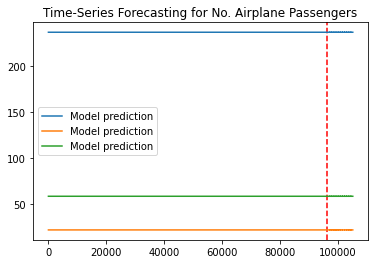

In [43]:
# predictions = sc.inverse_transform(predictions)
# labels = sc.inverse_transform(y.cpu().numpy())
labels = y.cpu().numpy()
plt.axvline(x=training_set_size, c='r', linestyle='--')
plt.plot(predictions, label='Model prediction')
# plt.plot(labels, label='Groundtruth')
plt.legend()
plt.title('Time-Series Forecasting for No. Airplane Passengers')
plt.show()

In [36]:
# predictions[0] -> train[9]
# 96361

In [46]:
predictions[0]

array([236.25958 ,  22.13742 ,  58.587597], dtype=float32)

In [38]:
y[1]

tensor([270.5294,   2.9413,  75.0918], device='cuda:0')

In [39]:
len(predictions)

105111

In [40]:
predictions[96361-9:]

array([[236.25958 ,  22.13742 ,  58.587597],
       [236.25958 ,  22.13742 ,  58.587597],
       [236.25958 ,  22.13742 ,  58.587597],
       ...,
       [236.25958 ,  22.13742 ,  58.587597],
       [236.25958 ,  22.13742 ,  58.587597],
       [236.25958 ,  22.13742 ,  58.587597]], dtype=float32)

In [44]:
labels[96361-9:]

array([[0.    , 5.5313, 0.    ],
       [0.    , 5.8106, 0.    ],
       [0.    , 5.3325, 0.    ],
       ...,
       [0.    , 8.5637, 0.    ],
       [0.    , 7.9824, 0.    ],
       [0.    , 7.7303, 0.    ]], dtype=float32)

In [45]:
test_df[test_df['Temperature(C)'].isnull()]

,Hour,Solar Radiance(w/m^2),Temperature(C),Solar Power(kW),Month,Day,Year
744,0,NaN,NaN,NaN,2,1,2020
745,1,NaN,NaN,NaN,2,1,2020
746,2,NaN,NaN,NaN,2,1,2020
747,3,NaN,NaN,NaN,2,1,2020
748,4,NaN,NaN,NaN,2,1,2020
...,...,...,...,...,...,...,...
8179,19,NaN,NaN,NaN,12,7,2020
8180,20,NaN,NaN,NaN,12,7,2020
8181,21,NaN,NaN,NaN,12,7,2020
8182,22,NaN,NaN,NaN,12,7,2020


In [318]:
sample = pd.DataFrame(columns=['ID','Month','Day','Hour','Solar Radiance(w/m^2)','Temperature(C)','Solar Power(kW)'])

In [319]:
for i, (r,t,p) in tqdm(enumerate(y_pred_test)):
    if test_df2.iloc[i].isnull()['Temperature(C)']:
        test_df.loc[i,['Solar Radiance(w/m^2)','Temperature(C)','Solar Power(kW)']] = r,t,p
        sample = sample.append(test_df.iloc[i], ignore_index=True)

0it [00:00, ?it/s]

In [ ]:
# # 제출 파일
# cnt = 0
# for i,(r,t,p) in tqdm(enumerate(predictions[96361-5:])):
#     if test_df.iloc[i].isnull()['Temperature(C)']:
#         test_df.loc[i,['Solar Radiance(w/m^2)','Temperature(C)','Solar Power(kW)']] = r,t,p
#         sample = sample.append(test_df.iloc[i], ignore_index=True)

In [320]:
sample

,ID,Month,Day,Hour,Solar Radiance(w/m^2),Temperature(C),Solar Power(kW),Year
0,NaN,2,1,0,16.224218,13.759330,4.370647,2020
1,NaN,2,1,1,15.583576,13.249042,3.959789,2020
2,NaN,2,1,2,15.134786,12.842404,3.592353,2020
3,NaN,2,1,3,15.801853,12.505739,3.551673,2020
4,NaN,2,1,4,17.651140,12.219271,3.876907,2020
...,...,...,...,...,...,...,...,...
1843,NaN,12,7,19,21.905025,8.823795,5.414330,2020
1844,NaN,12,7,20,18.657352,8.588179,4.718915,2020
1845,NaN,12,7,21,17.569592,8.381631,4.505817,2020
1846,NaN,12,7,22,17.362999,8.182215,4.510054,2020


In [ ]:
test_df

In [321]:
sample['ID'] = range(1848)
# df.append(pd.Series(row, index=df.columns), ignore_index=True)
# print_df(df6)

In [327]:
sample.describe()

,ID,Solar Radiance(w/m^2),Temperature(C),Solar Power(kW)
count,1848.000000,1848.000000,1848.000000,1848.000000
mean,923.500000,164.927207,23.315209,39.198679
std,533.615967,199.010581,9.575708,49.268018
min,0.000000,0.000000,7.287425,0.000000
25%,461.750000,18.196404,14.818636,2.983478
50%,923.500000,49.502104,23.236141,10.271639
75%,1385.250000,281.595589,31.081442,68.604841
max,1847.000000,733.248596,44.041733,185.017059


In [326]:
sample.loc[sample['Solar Radiance(w/m^2)']<0,'Solar Radiance(w/m^2)'] = 0
sample.loc[sample['Solar Power(kW)']<0,'Solar Power(kW)'] = 0

In [323]:
del sample['Year']

In [328]:
# sample

In [329]:
sample.to_csv('./prediction2.csv', index=False)